### 環境配置與導入所需的套件

In [1]:
import os
import torch
os.environ['KMP_DUPLICATE_LIB_OK']='True'
torch.backends.cudnn.benchmark=True

import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision import models as m
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from time import time
import datetime
import random
import numpy as np
import pandas as pd
import gc

In [2]:
torch.manual_seed(1412)
random.seed(1412)
np.random.seed(1412)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 導入SVHN數據集，查看數據(數據結構、可視化)

In [4]:
train = torchvision.datasets.SVHN(root = r'D:\TGI102_AI_BootCamp\Pytorch\datasets\L17\SVHN'
                                 ,split ="train"
                                 ,download = False
                                 ,transform = T.ToTensor()
                                 )

In [5]:
train

Dataset SVHN
    Number of datapoints: 73257
    Root location: D:\TGI102_AI_BootCamp\Pytorch\datasets\L17\SVHN
    Split: train
    StandardTransform
Transform: ToTensor()

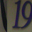

In [7]:
train[0][0]

In [7]:
for x, y in train:
    print(x.shape)
    print(y)
    break

torch.Size([3, 32, 32])
1


In [8]:
np.unique(train.labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [46]:
test = torchvision.datasets.SVHN(root = r'D:\TGI102_AI_BootCamp\Pytorch\datasets\L17\SVHN'
                                 ,split ="test"
                                 ,download = False
                                 ,transform = T.ToTensor()
                                )

In [13]:
test

Dataset SVHN
    Number of datapoints: 26032
    Root location: D:\TGI102_AI_BootCamp\Pytorch\datasets\L17\SVHN
    Split: test

In [49]:
for x, y in test:
    print(x.shape)
    print(y)
    break

torch.Size([3, 32, 32])
5


In [4]:
def plotsample(data):
    fig, axs = plt.subplots(1,10,figsize=(10,10))
    for i in range(10):
        num = random.randint(0,len(data)-1)
        npimg = torchvision.utils.make_grid(data[num][0]).numpy()
        nplabel = data[num][1]
        axs[i].imshow(np.transpose(npimg, (1, 2, 0))) 
        axs[i].set_title(nplabel)
        axs[i].axis("off")

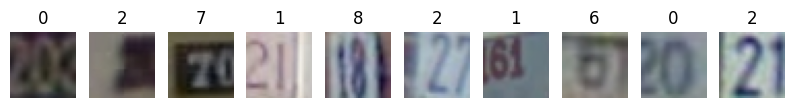

In [28]:
plotsample(train)

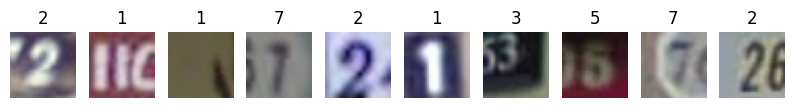

In [32]:
plotsample(test)

### 數據預處理

In [4]:
trainT = T.Compose([T.RandomCrop(28)
                   ,T.RandomRotation(degrees = [-15,15])
                   ,T.RandomAdjustSharpness(2, p=0.5)
                   ,T.ToTensor()
                   ,T.Normalize(mean = [0.485,0.456,0.406]
                                ,std = [0.229,0.224,0.225])
                   ])

In [5]:
train = torchvision.datasets.SVHN(root = r'D:\TGI102_AI_BootCamp\Pytorch\datasets\L17\SVHN'
                                 ,split ="train"
                                 ,download = False
                                 ,transform = trainT
                                 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

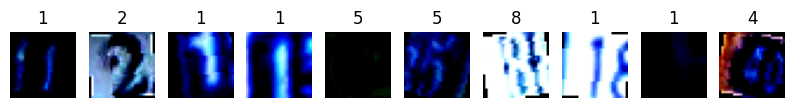

In [44]:
plotsample(train)

In [6]:
testT = T.Compose([T.CenterCrop(28)
                  ,T.RandomAdjustSharpness(2, p=1)
                  ,T.ToTensor()
                  ,T.Normalize(mean = [0.485,0.456,0.406]
                                ,std = [0.229,0.224,0.225])
                  ])

In [7]:
test = torchvision.datasets.SVHN(root = r'D:\TGI102_AI_BootCamp\Pytorch\datasets\L17\SVHN'
                                 ,split ="test"
                                 ,download = False
                                 ,transform = testT
                                 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

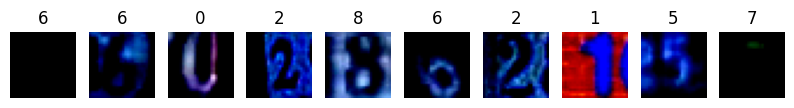

In [47]:
plotsample(test)

### 建立Resnet 模型

In [86]:
torch.manual_seed(1412)
resnet18_ = m.resnet18()

resnet18_

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
class CustomResNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.block1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
                                    resnet18_.bn1,
                                    resnet18_.relu)
        
        self.block2 = resnet18_.layer2
        self.block3 = resnet18_.layer3
        self.block4 = resnet18_.layer4
        
        self.avgpool = resnet18_.avgpool
        self.fc = nn.Linear(512, 10, bias=True)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.avgpool(x)
#         x = x.view(x.shape[0], 512)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [89]:
from torchinfo import summary

In [117]:
net = CustomResNet()
summary(net, (10, 3, 28, 28), depth=2, device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
CustomResNet                             [10, 10]                  --
├─Sequential: 1-1                        [10, 64, 28, 28]          --
│    └─Conv2d: 2-1                       [10, 64, 28, 28]          1,728
│    └─BatchNorm2d: 2-2                  [10, 64, 28, 28]          128
│    └─ReLU: 2-3                         [10, 64, 28, 28]          --
├─Sequential: 1-2                        [10, 128, 14, 14]         --
│    └─BasicBlock: 2-4                   [10, 128, 14, 14]         230,144
│    └─BasicBlock: 2-5                   [10, 128, 14, 14]         295,424
├─Sequential: 1-3                        [10, 256, 7, 7]           --
│    └─BasicBlock: 2-6                   [10, 256, 7, 7]           919,040
│    └─BasicBlock: 2-7                   [10, 256, 7, 7]           1,180,672
├─Sequential: 1-4                        [10, 512, 4, 4]           --
│    └─BasicBlock: 2-8                   [10, 512, 4, 4]   

### 定義與訓練/測試相關的函數(使用GPU)

#### 提前停止函數
當連續n次：　1.損失差值小於閾值　2. 新一次損失大於歷史最低損失(訓練效果越來越差)，即提前停止訓練

In [9]:
class EarlyStopping():
    # 慣例的定義我們所需要的一切變量/屬性
    def __init__(self, patience=5, tol=0.0005):  
        """
        當連續patience次迭代時，每一輪迭代的損失與歷史最低損失之間的差值小於閾值時
        就觸發提前停止(代表下次訓練準確率/Loss沒有上次訓練好, 可能是過擬合; 或模型已收斂, loss無法再降低)
        """
        self.patience = patience
        self.tol = tol  # tolerance, 累積patience次都低於tol才會觸發停止
        self.counter = 0 # 計數, 計算現在已經累積了counter次
        self.lowest_loss = None
        self.early_stop = False  # True - 提前停止, False -不要提前停止
        
    def __call__(self, val_loss):
        if self.lowest_loss == None:  # 這是第一輪迭代
            self.lowest_loss = val_loss
        elif self.lowest_loss - val_loss > self.tol:
            self.lowest_loss = val_loss
            self.counter = 0
        elif self.lowest_loss - val_loss < self.tol:
            self.counter += 1
            print("\t NOTICE: Early stopping counter {} of {}".format(self.counter,self.patience))
            if self.counter >= self.patience:
                print('\t NOTICE: Early Stopping Actived')
                self.early_stop = True
                
        return self.early_stop
        
        # 這一輪迭代的損失與歷史最低損失之間的差 - 閾值

In [10]:
def IterOnce(net,criterion,opt,x,y):
    """
    對模型進行一次迭代的函數
    
    net: 實例化後的架構
    criterion: 損失函數
    opt: 優化算法
    x: 這一個batch中所有的樣本
    y: 這一個batch中所有樣本的真實標籤
    """
    sigma = net.forward(x)
    loss = criterion(sigma,y)
    loss.backward()
    opt.step()
    opt.zero_grad(set_to_none=True) # 比起設置梯度為0，讓梯度為None會更節約內存
    yhat = torch.max(sigma,1)[1]
    correct = torch.sum(yhat == y)
    return correct,loss

In [11]:
def TestOnce(net,criterion,x,y):
    """
    對一組數據進行測試並輸出測試結果的函數
    
    net: 經過訓練後的架構
    criterion：損失函數
    x：要測試的數據的所有樣本
    y：要測試的數據的真實標籤
    """
    #對測試，一定要阻止計算圖追蹤
    #這樣可以節省很多內存，加速運算
    with torch.no_grad(): 
        sigma = net.forward(x)
        loss = criterion(sigma,y)
        yhat = torch.max(sigma,1)[1]
        correct = torch.sum(yhat == y)
    return correct,loss

In [12]:
torch.cuda.manual_seed(1412)
torch.cuda.manual_seed_all(1412)

In [13]:
def fit_test(net,batchdata,testdata,criterion,opt,epochs,patience,tol,modelname,PATH):
    """
    對模型進行訓練，並在每個epoch後輸出訓練集和測試集上的準確率/損失
    以實現對模型的監控
    實現模型的保存
    
    參數說明：
    net: 實例化後的網絡
    batchdata：使用Dataloader分割後的訓練數據
    testdata：使用Dataloader分割後的測試數據
    criterion：所使用的損失函數
    opt：所使用的優化算法
    epochs：一共要使用完整數據集epochs次
    tol：提前停止時測試集上loss下降的閾值，連續5次loss下降不超過tol就會觸發提前停止
    modelname：現在正在運行的模型名稱，用於保存權重時作為文件名
    PATH：將權重文件保存在path目錄下
    
    """
    
    SamplePerEpoch = batchdata.dataset.__len__() # 整個epoch裡有多少個樣本
    allsamples = SamplePerEpoch*epochs
    trainedsamples = 0
    trainlosslist = []
    testlosslist = []
    trainacclist = []
    testacclist = []
    early_stopping = EarlyStopping(patience=patience, tol=tol)
    highestacc = None
    
    for epoch in range(1,epochs+1):
        net.train()
        correct_train = 0
        loss_train = 0
        for batch_idx, (x, y) in enumerate(batchdata):
            # non_blocking 非阻塞 = True, ex.假設分配100資源給80數據, 剩下20資源可以挪給其他數據使用
            x = x.to(device,non_blocking=True)
            y = y.to(device,non_blocking=True).view(x.shape[0])
            correct, loss = IterOnce(net,criterion,opt,x,y)
            
            # 計算樣本總量、總的correct、loss
            trainedsamples += x.shape[0]
            loss_train += loss
            correct_train += correct
            
            if (batch_idx+1) % 125 == 0:
                # 現在進行到了哪個epoch
                # 現在訓練到了多少個樣本
                # 總共要訓練多少個樣本
                # 現在的訓練的樣本佔總共需要訓練的樣本的百分比
                print('Epoch{}:[{}/{}({:.0f}%)]'.format(epoch
                                                       ,trainedsamples
                                                       ,allsamples
                                                       ,100*trainedsamples/allsamples))
            
        TrainAccThisEpoch = float(correct_train*100)/SamplePerEpoch
        TrainLossThisEpoch = float(loss_train*100)/SamplePerEpoch # 平均每個樣本上的損失
        trainacclist.append(TrainAccThisEpoch)
        trainlosslist.append(TrainLossThisEpoch)
        
        # 清理GPU內存
        # 清理掉一個epoch循環下面不再需要的中間變量
        del x,y,correct,loss,correct_train,loss_train # 刪除數據與變量
        gc.collect() # 清除數據與變量相關的緩存
        torch.cuda.empty_cache() # 緩存分配器分配出去的內存給釋放掉
    
        #每次訓練完一個epoch，就在測試集上驗證一下模型現在的效果
        net.eval()
        loss_test = 0
        correct_test = 0
        loss_test = 0
        TestSample = testdata.dataset.__len__()

        for x,y in testdata:
            x = x.to(device, non_blocking=True)
            y = y.to(device,non_blocking=True).view(x.shape[0])
            correct, loss = TestOnce(net,criterion,x,y)
            loss_test += loss
            correct_test += correct

        TestAccThisEpoch = float(correct_test * 100)/TestSample
        TestLossThisEpoch = float(loss_test * 100)/TestSample
        testacclist.append(TestAccThisEpoch)
        testlosslist.append(TestLossThisEpoch)
        
        #清理GPU內存
        del x,y,correct,loss,correct_test,loss_test
        gc.collect()
        torch.cuda.empty_cache()
        
        #對每一個epoch，打印訓練和測試的結果
        #訓練集上的損失，測試集上的損失，訓練集上的準確率，測試集上的準確率
        print("\t Train Loss:{:.6f}, Test Loss:{:.6f}, Train Acc:{:.3f}%, Test Acc:{:.3f}%".format(TrainLossThisEpoch
                                                                                                  ,TestLossThisEpoch
                                                                                                  ,TrainAccThisEpoch
                                                                                                  ,TestAccThisEpoch))
        
        #如果測試集準確率出現新高/測試集loss出現新低，那我會保存現在的這一組權重
        if highestacc == None: #首次進行測試
            highestacc = TestAccThisEpoch
        if highestacc < TestAccThisEpoch:
            highestacc = TestAccThisEpoch
            torch.save(net.state_dict(),os.path.join(PATH,modelname+".pt"))
            print("\t Weight Saved")
        
        #提前停止
        early_stop = early_stopping(TestLossThisEpoch)
        if early_stop == True:
            break
            
    print("Complete")
    return trainlosslist, testlosslist, trainacclist, testacclist

### 準備訓練所需的所有參數
net, batchdata, testdata, criterion, opt, epochs, tol, modelname, PATH

In [16]:
train

Dataset SVHN
    Number of datapoints: 73257
    Root location: D:\TGI102_AI_BootCamp\Pytorch\datasets\L17\SVHN
    Split: train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(28, 28), padding=None)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomAdjustSharpness(sharpness_factor=2,p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [17]:
test

Dataset SVHN
    Number of datapoints: 26032
    Root location: D:\TGI102_AI_BootCamp\Pytorch\datasets\L17\SVHN
    Split: test
    StandardTransform
Transform: Compose(
               CenterCrop(size=(28, 28))
               RandomAdjustSharpness(sharpness_factor=2,p=1)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [19]:
def full_procedure(net,epochs,bs,modelname, PATH, lr=0.001,alpha=0.99,gamma=0,wd=0,patience=5,tol=10**(-5)):
    
    torch.cuda.manual_seed(1412)
    torch.cuda.manual_seed_all(1412)
    torch.manual_seed(1412)
    
    #分割數據
    batchdata = DataLoader(train,batch_size=bs,shuffle=True
                       ,drop_last=False)
    testdata = DataLoader(test,batch_size=bs,shuffle=False
                      ,drop_last=False)
    
    #損失函數，優化算法
    criterion = nn.CrossEntropyLoss(reduction="sum") #進行損失函數計算時，最後輸出結果的計算模式
    opt = optim.RMSprop(net.parameters(),lr=lr
                        ,alpha=alpha,momentum=gamma,weight_decay=wd)
    
    #訓練與測試
    trainloss, testloss, trainacc, testacc = fit_test(net,batchdata,testdata,criterion,opt,epochs,patience,tol,modelname,PATH)
    
    return trainloss, testloss, trainacc, testacc

In [14]:
# 繪圖函數
def plotloss(trainloss, testloss):
    plt.figure(figsize=(10, 7))
    plt.plot(trainloss, color="red", label="Trainloss")
    plt.plot(testloss, color="orange", label="Testloss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [13]:
# 繪圖函數
def plotacc(trainacc, testacc):
    plt.figure(figsize=(10, 7))
    plt.plot(trainacc, color="red", label="Trainacc")
    plt.plot(testacc, color="orange", label="Testacc")
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

In [14]:
torch.cuda.memory_allocated() # 張量內存的佔用情況（現狀）
torch.cuda.memory_reserved() # 緩存分配器佔用的所有內存（現狀）
torch.cuda.max_memory_allocated() # 自GPU運行以來佔用過的最大張量內存（峰值）

0

### 訓練ResNet網路

CustomResNet_test0
Epoch1:[8000/732570(1%)]
Epoch1:[16000/732570(2%)]
Epoch1:[24000/732570(3%)]
Epoch1:[32000/732570(4%)]
Epoch1:[40000/732570(5%)]
Epoch1:[48000/732570(7%)]
Epoch1:[56000/732570(8%)]
Epoch1:[64000/732570(9%)]
Epoch1:[72000/732570(10%)]
	 Train Loss:95.103280, Test Loss:28.870784, Train Acc:68.062%, Test Acc:91.315%
Epoch2:[81257/732570(11%)]
Epoch2:[89257/732570(12%)]
Epoch2:[97257/732570(13%)]
Epoch2:[105257/732570(14%)]
Epoch2:[113257/732570(15%)]
Epoch2:[121257/732570(17%)]
Epoch2:[129257/732570(18%)]
Epoch2:[137257/732570(19%)]
Epoch2:[145257/732570(20%)]
	 Train Loss:38.683842, Test Loss:26.385526, Train Acc:88.041%, Test Acc:92.252%
	 Weight Saved
Epoch3:[154514/732570(21%)]
Epoch3:[162514/732570(22%)]
Epoch3:[170514/732570(23%)]
Epoch3:[178514/732570(24%)]
Epoch3:[186514/732570(25%)]
Epoch3:[194514/732570(27%)]
Epoch3:[202514/732570(28%)]
Epoch3:[210514/732570(29%)]
Epoch3:[218514/732570(30%)]
	 Train Loss:32.060339, Test Loss:22.374880, Train Acc:90.247%, Test 

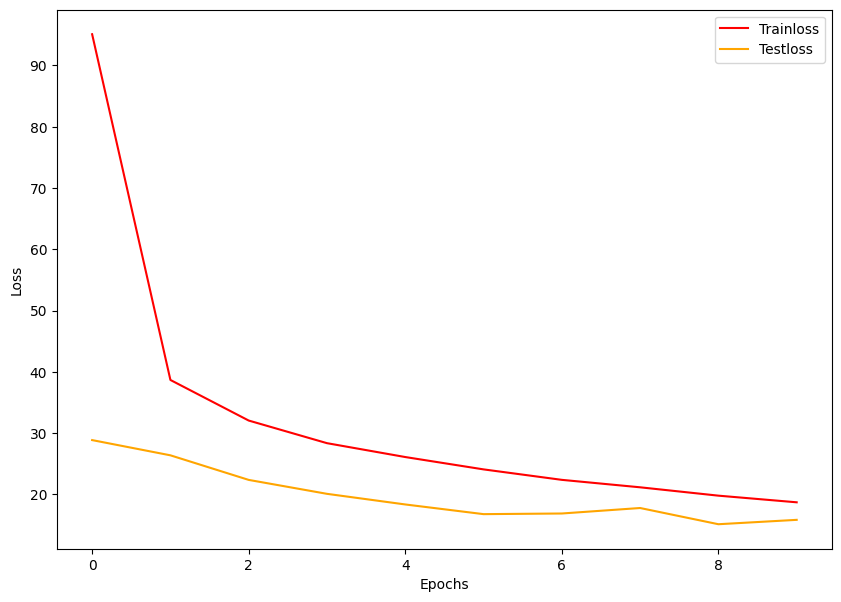

In [18]:
# 訓練10個epochs
PATH = r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights"
modelname = "CustomResNet_test0"

print(modelname)
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = CustomResNet().to(device,non_blocking=True)
start = time()
trainloss, testloss, trainacc, testacc = full_procedure(net,epochs=10, bs=64
                                          ,modelname=modelname
                                          ,PATH = PATH)
print(time()-start)
plotloss(trainloss,testloss)

In [20]:
# Trainloss > Testloss, 模型表現欠擬合, 再進行更多訓練
# 加載之前保存的權重, 調低tolerance, 再訓練20個Epoch
# 調大bs, 看testloss表現會不會變平穩
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = CustomResNet().to(device,non_blocking=True)
net.load_state_dict(torch.load(r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights\CustomResNet_test0.pt"))

<All keys matched successfully>

MyResNet_test1
Epoch1:[32000/1465140(2%)]
Epoch1:[64000/1465140(4%)]
	 Train Loss:17.301749, Test Loss:14.187152, Train Acc:94.948%, Test Acc:96.239%
Epoch2:[105257/1465140(7%)]
Epoch2:[137257/1465140(9%)]
	 Train Loss:14.374498, Test Loss:14.308405, Train Acc:95.933%, Test Acc:96.354%
	 Weight Saved
	 NOTICE: Early stopping counter 1 of 5
Epoch3:[178514/1465140(12%)]
Epoch3:[210514/1465140(14%)]
	 Train Loss:13.198763, Test Loss:13.647578, Train Acc:96.213%, Test Acc:96.485%
	 Weight Saved
Epoch4:[251771/1465140(17%)]
Epoch4:[283771/1465140(19%)]
	 Train Loss:12.272303, Test Loss:14.627478, Train Acc:96.419%, Test Acc:96.216%
	 NOTICE: Early stopping counter 1 of 5
Epoch5:[325028/1465140(22%)]
Epoch5:[357028/1465140(24%)]
	 Train Loss:11.204539, Test Loss:14.558000, Train Acc:96.748%, Test Acc:96.197%
	 NOTICE: Early stopping counter 2 of 5
Epoch6:[398285/1465140(27%)]
Epoch6:[430285/1465140(29%)]
	 Train Loss:10.604154, Test Loss:14.329119, Train Acc:97.050%, Test Acc:96.305%
	 NOTIC

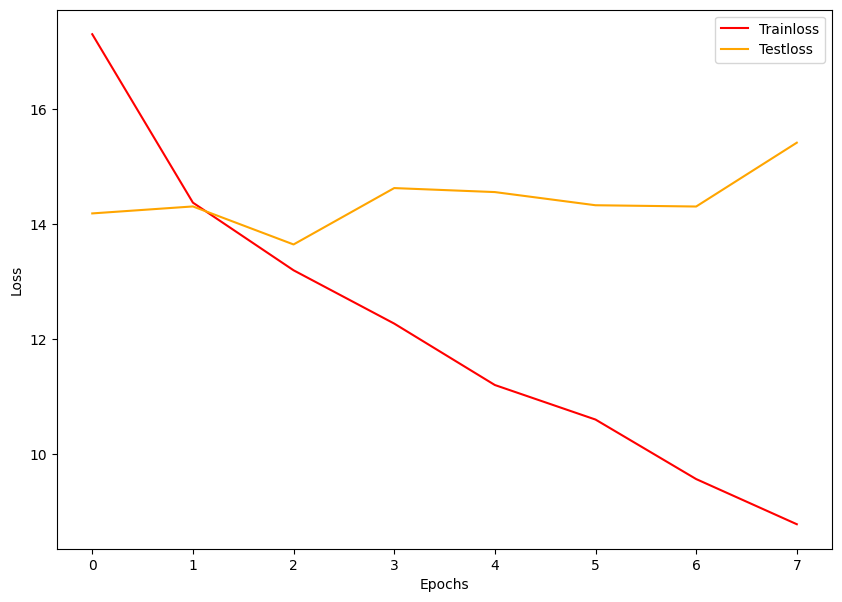

In [21]:
# 修改modelname，準備好保存結果
modelname = "MyResNet_test1"

print(modelname)
torch.manual_seed(1412)
start = time() 
trainloss, testloss, trainacc, testacc = full_procedure(net,epochs=20, bs=256
                                             ,modelname=modelname
                                             ,PATH = PATH 
                                             ,gamma=0
                                             ,tol = 10**(-10))
print(time()-start)
plotloss(trainloss,testloss)

MyResNet_test2
Epoch1:[32000/1465140(2%)]
Epoch1:[64000/1465140(4%)]
	 Train Loss:14.627856, Test Loss:12.858374, Train Acc:95.860%, Test Acc:96.681%
Epoch2:[105257/1465140(7%)]
Epoch2:[137257/1465140(9%)]
	 Train Loss:13.260823, Test Loss:12.742166, Train Acc:96.265%, Test Acc:96.742%
	 Weight Saved
Epoch3:[178514/1465140(12%)]
Epoch3:[210514/1465140(14%)]
	 Train Loss:12.379034, Test Loss:12.566386, Train Acc:96.490%, Test Acc:96.823%
	 Weight Saved
Epoch4:[251771/1465140(17%)]
Epoch4:[283771/1465140(19%)]
	 Train Loss:11.746111, Test Loss:12.615358, Train Acc:96.658%, Test Acc:96.815%
	 NOTICE: Early stopping counter 1 of 5
Epoch5:[325028/1465140(22%)]
Epoch5:[357028/1465140(24%)]
	 Train Loss:11.116157, Test Loss:12.671325, Train Acc:96.931%, Test Acc:96.777%
	 NOTICE: Early stopping counter 2 of 5
Epoch6:[398285/1465140(27%)]
Epoch6:[430285/1465140(29%)]
	 Train Loss:10.584041, Test Loss:12.729624, Train Acc:97.105%, Test Acc:96.808%
	 NOTICE: Early stopping counter 3 of 5
Epoch7:

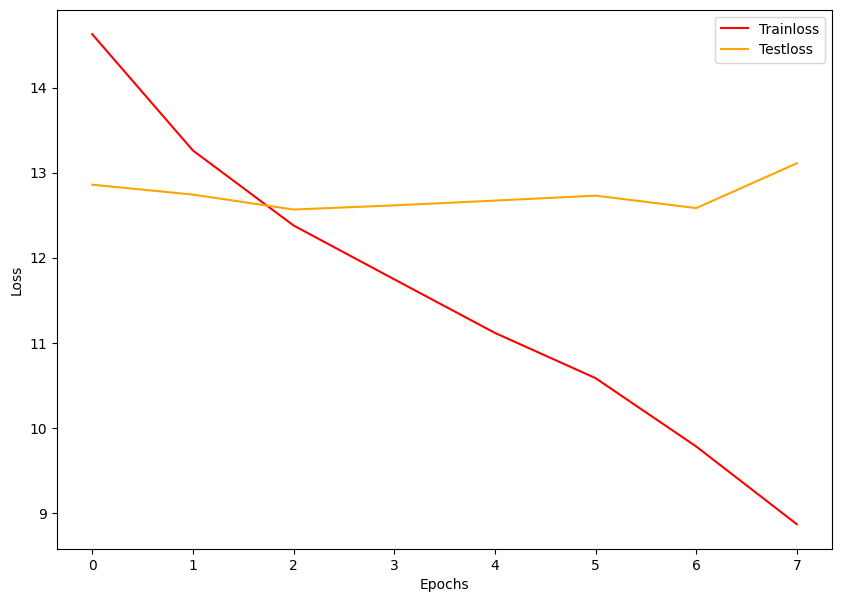

In [20]:
# trainloss有顯著下降並低於testloss, 多疊代幾輪有改善欠擬合
# testloss呈現不穩定且向上趨勢, 有輕微過擬合現象, 從訓練10個epoch的模型開始, 調低初始學習率做訓練
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = CustomResNet().to(device,non_blocking=True)
net.load_state_dict(torch.load(r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights\CustomResNet_test0.pt"))

PATH = r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights"
modelname = "MyResNet_test2"

print(modelname)
torch.manual_seed(1412)
start = time() 
trainloss, testloss, trainacc, testacc = full_procedure(net,epochs=20, bs=256
                                             ,modelname=modelname
                                             ,PATH = PATH 
                                             ,lr=0.0001
                                             ,gamma=0
                                             ,tol = 10**(-10))
print(time()-start)
plotloss(trainloss,testloss)

MyResNet_test3
Epoch1:[32000/1465140(2%)]
Epoch1:[64000/1465140(4%)]
	 Train Loss:14.628065, Test Loss:12.857183, Train Acc:95.858%, Test Acc:96.685%
Epoch2:[105257/1465140(7%)]
Epoch2:[137257/1465140(9%)]
	 Train Loss:13.260716, Test Loss:12.743988, Train Acc:96.260%, Test Acc:96.739%
	 Weight Saved
Epoch3:[178514/1465140(12%)]
Epoch3:[210514/1465140(14%)]
	 Train Loss:12.378923, Test Loss:12.569517, Train Acc:96.492%, Test Acc:96.827%
	 Weight Saved
Epoch4:[251771/1465140(17%)]
Epoch4:[283771/1465140(19%)]
	 Train Loss:11.746209, Test Loss:12.617859, Train Acc:96.658%, Test Acc:96.804%
	 NOTICE: Early stopping counter 1 of 5
Epoch5:[325028/1465140(22%)]
Epoch5:[357028/1465140(24%)]
	 Train Loss:11.116394, Test Loss:12.671708, Train Acc:96.927%, Test Acc:96.769%
	 NOTICE: Early stopping counter 2 of 5
Epoch6:[398285/1465140(27%)]
Epoch6:[430285/1465140(29%)]
	 Train Loss:10.584381, Test Loss:12.733321, Train Acc:97.099%, Test Acc:96.808%
	 NOTICE: Early stopping counter 3 of 5
Epoch7:

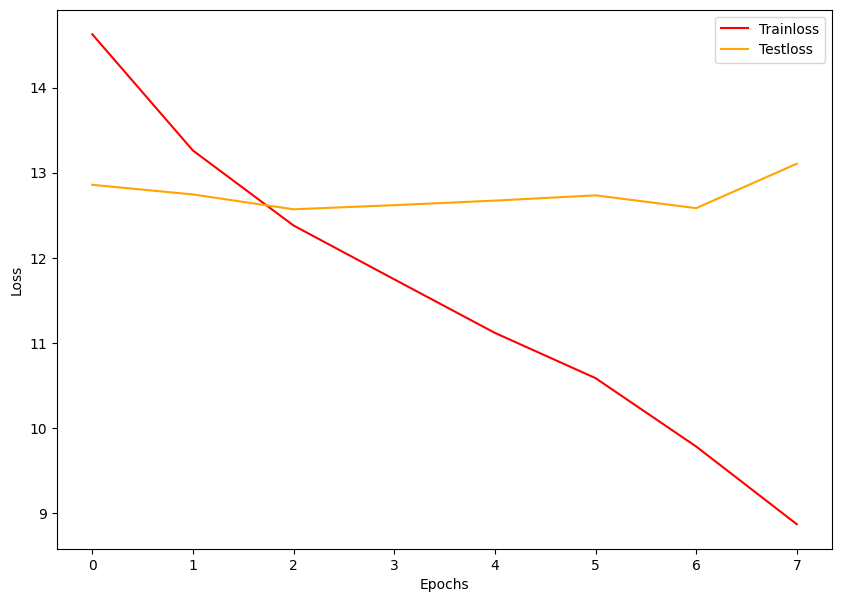

In [24]:
# 降低初始學習率, 有助於穩定損失下降, 這次調整gamma值來看看是否能幫助改善過擬合
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = CustomResNet().to(device,non_blocking=True)
net.load_state_dict(torch.load(r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights\CustomResNet_test0.pt"))

PATH = r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights"
modelname = "MyResNet_test3"

print(modelname)
torch.manual_seed(1412)
start = time() 
trainloss, testloss, trainacc, testacc = full_procedure(net,epochs=20, bs=256
                                             ,modelname=modelname
                                             ,PATH = PATH 
                                             ,lr=0.0001
                                             ,gamma=0.0005
                                             ,tol = 10**(-10))
print(time()-start)
plotloss(trainloss,testloss)

MyResNet_test3
Epoch1:[8000/1465140(1%)]
Epoch1:[16000/1465140(1%)]
Epoch1:[24000/1465140(2%)]
Epoch1:[32000/1465140(2%)]
Epoch1:[40000/1465140(3%)]
Epoch1:[48000/1465140(3%)]
Epoch1:[56000/1465140(4%)]
Epoch1:[64000/1465140(4%)]
Epoch1:[72000/1465140(5%)]
	 Train Loss:14.915651, Test Loss:12.895428, Train Acc:95.749%, Test Acc:96.716%
Epoch2:[81257/1465140(6%)]
Epoch2:[89257/1465140(6%)]
Epoch2:[97257/1465140(7%)]
Epoch2:[105257/1465140(7%)]
Epoch2:[113257/1465140(8%)]
Epoch2:[121257/1465140(8%)]
Epoch2:[129257/1465140(9%)]
Epoch2:[137257/1465140(9%)]
Epoch2:[145257/1465140(10%)]
	 Train Loss:13.414831, Test Loss:12.810932, Train Acc:96.247%, Test Acc:96.766%
	 Weight Saved
Epoch3:[154514/1465140(11%)]
Epoch3:[162514/1465140(11%)]
Epoch3:[170514/1465140(12%)]
Epoch3:[178514/1465140(12%)]
Epoch3:[186514/1465140(13%)]
Epoch3:[194514/1465140(13%)]
Epoch3:[202514/1465140(14%)]
Epoch3:[210514/1465140(14%)]
Epoch3:[218514/1465140(15%)]
	 Train Loss:12.441283, Test Loss:12.606552, Train Acc:

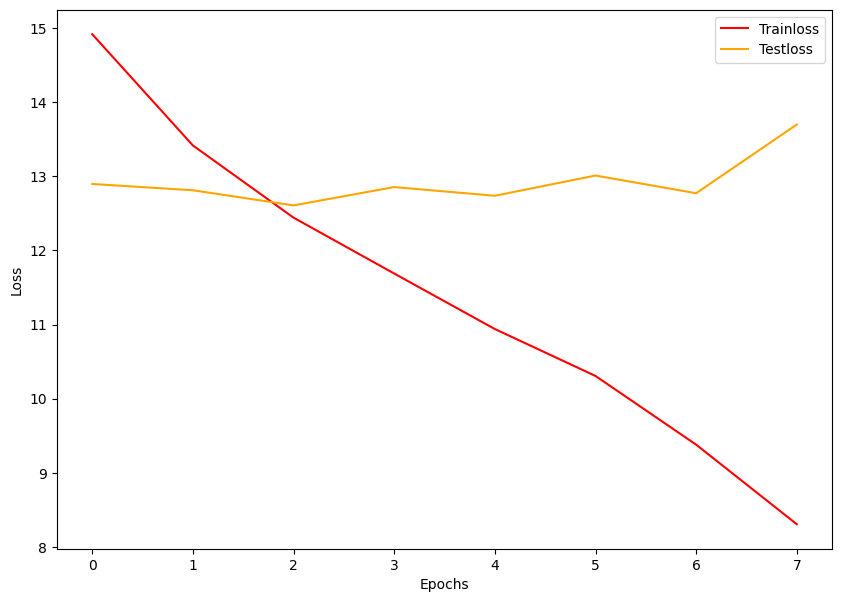

In [23]:
# 增加gamma似乎對於改善過擬合沒有太大幫助, 這次調整wd值來看看是否能幫助損失下降
# 降低bs來讓隨機性上升
# 提高tolerance來阻止訓練次數太多導致的過擬合
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = CustomResNet().to(device,non_blocking=True)
net.load_state_dict(torch.load(r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights\CustomResNet_test0.pt"))

PATH = r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights"
modelname = "MyResNet_test3"

print(modelname)
torch.manual_seed(1412)
start = time() 
trainloss, testloss, trainacc, testacc = full_procedure(net,epochs=20, bs=64
                                             ,modelname=modelname
                                             ,PATH = PATH 
                                             ,lr=0.0001
                                             ,gamma=0
                                             ,tol = 10**(-4)
                                             ,wd = 0.00005)
print(time()-start)
plotloss(trainloss,testloss)

MyResNet_test3
Epoch1:[16000/1465140(1%)]
Epoch1:[32000/1465140(2%)]
Epoch1:[48000/1465140(3%)]
Epoch1:[64000/1465140(4%)]
	 Train Loss:14.717607, Test Loss:12.891734, Train Acc:95.853%, Test Acc:96.654%
Epoch2:[89257/1465140(6%)]
Epoch2:[105257/1465140(7%)]
Epoch2:[121257/1465140(8%)]
Epoch2:[137257/1465140(9%)]
	 Train Loss:13.245280, Test Loss:12.776088, Train Acc:96.269%, Test Acc:96.754%
	 Weight Saved
Epoch3:[162514/1465140(11%)]
Epoch3:[178514/1465140(12%)]
Epoch3:[194514/1465140(13%)]
Epoch3:[210514/1465140(14%)]
	 Train Loss:12.357321, Test Loss:12.577931, Train Acc:96.489%, Test Acc:96.831%
	 Weight Saved
Epoch4:[235771/1465140(16%)]
Epoch4:[251771/1465140(17%)]
Epoch4:[267771/1465140(18%)]
Epoch4:[283771/1465140(19%)]
	 Train Loss:11.679358, Test Loss:12.683403, Train Acc:96.710%, Test Acc:96.800%
	 NOTICE: Early stopping counter 1 of 3
Epoch5:[309028/1465140(21%)]
Epoch5:[325028/1465140(22%)]
Epoch5:[341028/1465140(23%)]
Epoch5:[357028/1465140(24%)]
	 Train Loss:10.979672, 

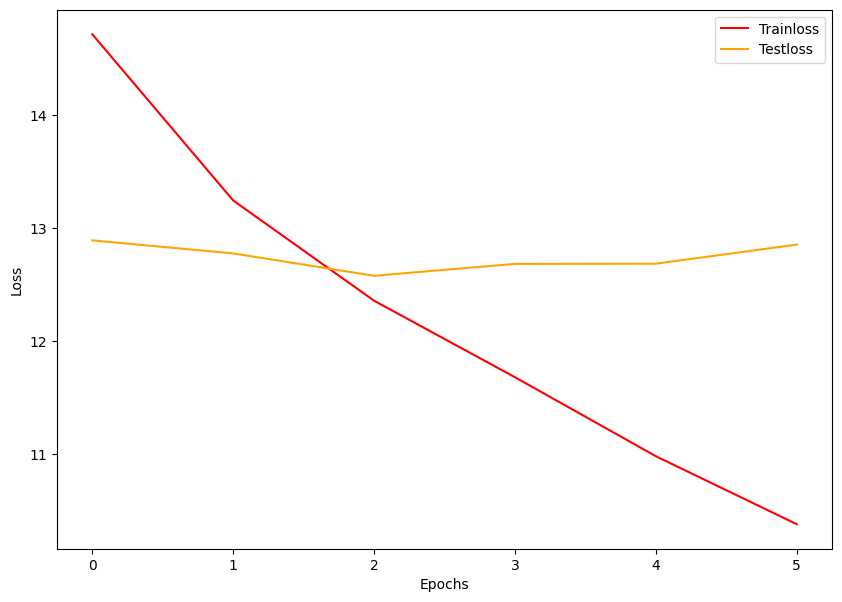

In [29]:
# 提升bs來讓訓練更穩定
# 降低patience來阻止訓練次數太多導致的過擬合
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = CustomResNet().to(device,non_blocking=True)
net.load_state_dict(torch.load(r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights\CustomResNet_test0.pt"))

PATH = r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights"
modelname = "MyResNet_test3"

print(modelname)
torch.manual_seed(1412)
start = time() 
trainloss, testloss, trainacc, testacc = full_procedure(net,epochs=20, bs=128
                                             ,modelname=modelname
                                             ,PATH = PATH 
                                             ,lr=0.0001
                                             ,gamma=0
                                             ,patience=3
                                             ,tol = 10**(-4)
                                             ,wd = 0)
print(time()-start)
plotloss(trainloss,testloss)

-------------------------------------

### 在數據增強部分增加新的增強手段

In [29]:
trainT = T.Compose([T.RandomCrop(28)
                   ,T.RandomRotation(degrees = [-15,15])
                   ,T.RandomAdjustSharpness(2, p=0.5)
                   ,T.ColorJitter(contrast=(0, 5))
                   ,T.ToTensor()
                   ,T.Normalize(mean = [0.485,0.456,0.406]
                                ,std = [0.229,0.224,0.225])
                   ])

In [30]:
train = torchvision.datasets.SVHN(root = r'D:\TGI102_AI_BootCamp\Pytorch\datasets\L17\SVHN'
                                 ,split ="train"
                                 ,download = False
                                 ,transform = trainT
                                 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

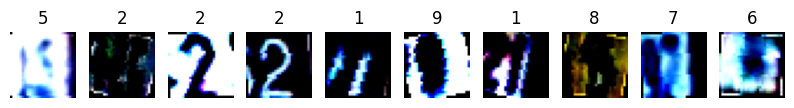

In [31]:
plotsample(train)

In [32]:
testT = T.Compose([T.CenterCrop(28)
                  ,T.RandomAdjustSharpness(2, p=0.5)
                  ,T.ColorJitter(contrast=(0, 5))
                  ,T.ToTensor()
                  ,T.Normalize(mean = [0.485,0.456,0.406]
                                ,std = [0.229,0.224,0.225])
                  ])

In [33]:
test = torchvision.datasets.SVHN(root = r'D:\TGI102_AI_BootCamp\Pytorch\datasets\L17\SVHN'
                                 ,split ="test"
                                 ,download = False
                                 ,transform = testT
                                 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

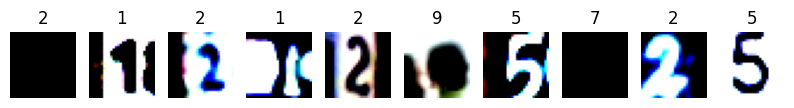

In [34]:
plotsample(test)

CustomResNet_test0_retrain
Epoch1:[8000/732570(1%)]
Epoch1:[16000/732570(2%)]
Epoch1:[24000/732570(3%)]
Epoch1:[32000/732570(4%)]
Epoch1:[40000/732570(5%)]
Epoch1:[48000/732570(7%)]
Epoch1:[56000/732570(8%)]
Epoch1:[64000/732570(9%)]
Epoch1:[72000/732570(10%)]
	 Train Loss:94.354676, Test Loss:35.032731, Train Acc:68.669%, Test Acc:89.732%
Epoch2:[81257/732570(11%)]
Epoch2:[89257/732570(12%)]
Epoch2:[97257/732570(13%)]
Epoch2:[105257/732570(14%)]
Epoch2:[113257/732570(15%)]
Epoch2:[121257/732570(17%)]
Epoch2:[129257/732570(18%)]
Epoch2:[137257/732570(19%)]
Epoch2:[145257/732570(20%)]
	 Train Loss:43.279233, Test Loss:30.130059, Train Acc:86.591%, Test Acc:91.230%
	 Weight Saved
Epoch3:[154514/732570(21%)]
Epoch3:[162514/732570(22%)]
Epoch3:[170514/732570(23%)]
Epoch3:[178514/732570(24%)]
Epoch3:[186514/732570(25%)]
Epoch3:[194514/732570(27%)]
Epoch3:[202514/732570(28%)]
Epoch3:[210514/732570(29%)]
Epoch3:[218514/732570(30%)]
	 Train Loss:36.353867, Test Loss:22.807811, Train Acc:89.015

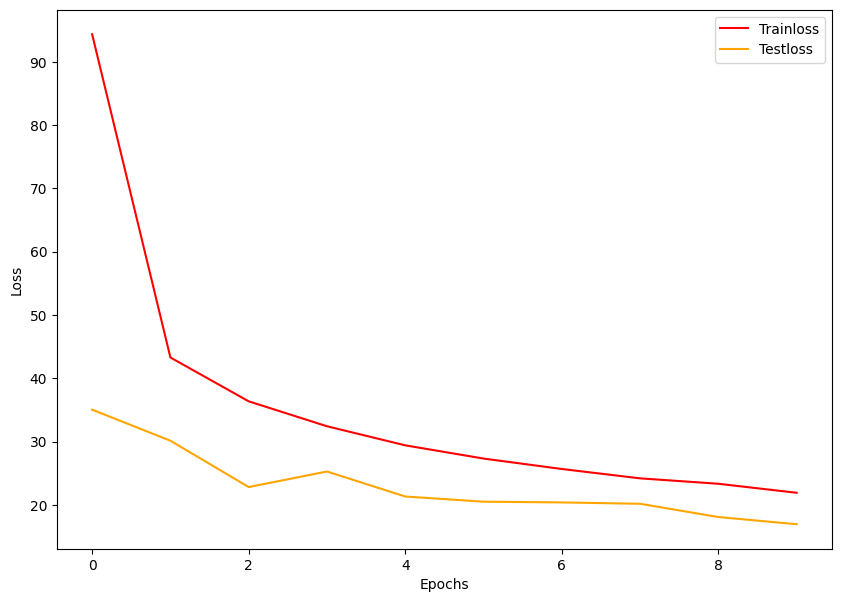

In [35]:
# 訓練10個epochs
PATH = r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights"
modelname = "CustomResNet_test0_retrain"

print(modelname)
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = CustomResNet().to(device,non_blocking=True)
start = time()
trainloss, testloss, trainacc, testacc = full_procedure(net,epochs=10, bs=64
                                          ,modelname=modelname
                                          ,PATH = PATH)
print(time()-start)
plotloss(trainloss,testloss)

In [36]:
# Trainloss > Testloss, 模型表現欠擬合, 再進行更多訓練
# 加載之前保存的權重, 調低tolerance, 再訓練20個Epoch
# 調大bs, 看testloss表現會不會變平穩
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = CustomResNet().to(device,non_blocking=True)
net.load_state_dict(torch.load(r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights\CustomResNet_test0_retrain.pt"))

<All keys matched successfully>

MyResNet_test1_retrain
Epoch1:[32000/1465140(2%)]
Epoch1:[64000/1465140(4%)]
	 Train Loss:19.393570, Test Loss:16.121782, Train Acc:94.354%, Test Acc:95.671%
Epoch2:[105257/1465140(7%)]
Epoch2:[137257/1465140(9%)]
	 Train Loss:16.491967, Test Loss:14.993119, Train Acc:95.210%, Test Acc:95.997%
	 Weight Saved
Epoch3:[178514/1465140(12%)]
Epoch3:[210514/1465140(14%)]
	 Train Loss:15.332303, Test Loss:15.389497, Train Acc:95.538%, Test Acc:95.870%
	 NOTICE: Early stopping counter 1 of 5
Epoch4:[251771/1465140(17%)]
Epoch4:[283771/1465140(19%)]
	 Train Loss:14.242702, Test Loss:15.585661, Train Acc:95.761%, Test Acc:95.832%
	 NOTICE: Early stopping counter 2 of 5
Epoch5:[325028/1465140(22%)]
Epoch5:[357028/1465140(24%)]
	 Train Loss:13.355531, Test Loss:16.280938, Train Acc:96.060%, Test Acc:95.759%
	 NOTICE: Early stopping counter 3 of 5
Epoch6:[398285/1465140(27%)]
Epoch6:[430285/1465140(29%)]
	 Train Loss:12.527729, Test Loss:15.318601, Train Acc:96.346%, Test Acc:95.878%
	 NOTICE: Earl

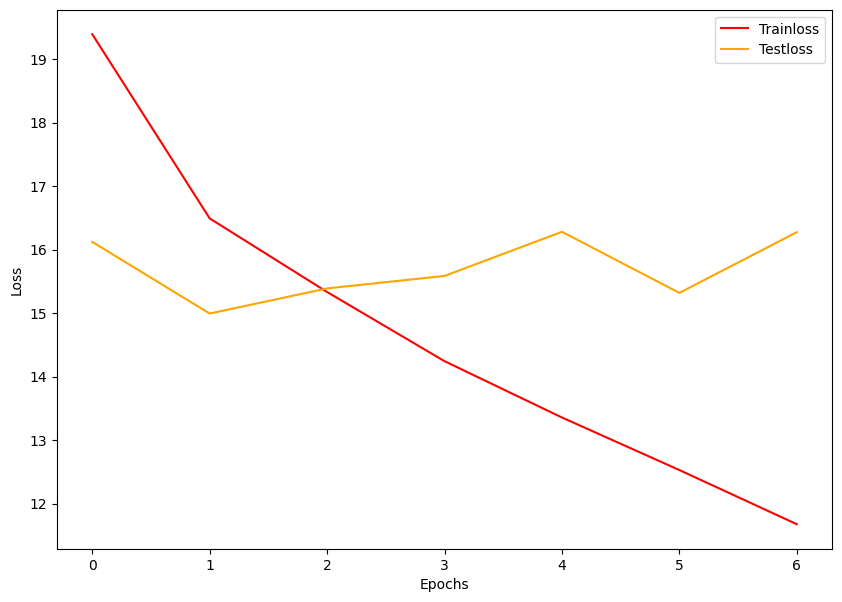

In [37]:
# 修改modelname，準備好保存結果
modelname = "MyResNet_test1_retrain"

print(modelname)
torch.manual_seed(1412)
start = time() 
trainloss, testloss, trainacc, testacc = full_procedure(net,epochs=20, bs=256
                                             ,modelname=modelname
                                             ,PATH = PATH 
                                             ,gamma=0
                                             ,tol = 10**(-10))
print(time()-start)
plotloss(trainloss,testloss)

MyResNet_test2_retrain
Epoch1:[32000/1465140(2%)]
Epoch1:[64000/1465140(4%)]
	 Train Loss:16.666447, Test Loss:14.083481, Train Acc:95.199%, Test Acc:96.262%
Epoch2:[105257/1465140(7%)]
Epoch2:[137257/1465140(9%)]
	 Train Loss:15.104135, Test Loss:13.883484, Train Acc:95.666%, Test Acc:96.331%
	 Weight Saved
Epoch3:[178514/1465140(12%)]
Epoch3:[210514/1465140(14%)]
	 Train Loss:14.402555, Test Loss:14.018146, Train Acc:95.823%, Test Acc:96.393%
	 Weight Saved
	 NOTICE: Early stopping counter 1 of 5
Epoch4:[251771/1465140(17%)]
Epoch4:[283771/1465140(19%)]
	 Train Loss:13.621999, Test Loss:13.800233, Train Acc:96.073%, Test Acc:96.351%
Epoch5:[325028/1465140(22%)]
Epoch5:[357028/1465140(24%)]
	 Train Loss:12.998939, Test Loss:13.819635, Train Acc:96.243%, Test Acc:96.401%
	 Weight Saved
	 NOTICE: Early stopping counter 1 of 5
Epoch6:[398285/1465140(27%)]
Epoch6:[430285/1465140(29%)]
	 Train Loss:12.439049, Test Loss:13.665280, Train Acc:96.544%, Test Acc:96.431%
	 Weight Saved
Epoch7:[4

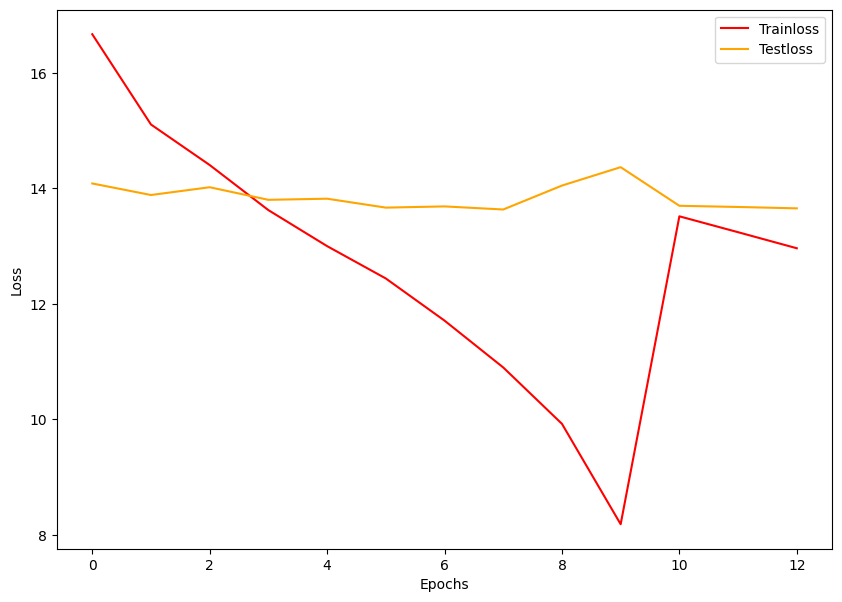

In [38]:
# trainloss有顯著下降並低於testloss, 多疊代幾輪有改善欠擬合
# testloss呈現不穩且向上趨勢, 有輕微過擬合現象, 從訓練10個epoch的模型開始, 調低初始學習率做訓練
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = CustomResNet().to(device,non_blocking=True)
net.load_state_dict(torch.load(r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights\CustomResNet_test0_retrain.pt"))

PATH = r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights"
modelname = "MyResNet_test2_retrain"

print(modelname)
torch.manual_seed(1412)
start = time() 
trainloss, testloss, trainacc, testacc = full_procedure(net,epochs=20, bs=256
                                             ,modelname=modelname
                                             ,PATH = PATH 
                                             ,lr=0.0001
                                             ,gamma=0
                                             ,tol = 10**(-10))
print(time()-start)
plotloss(trainloss,testloss)

MyResNet_test2_retrain
Epoch1:[16000/659313(2%)]
Epoch1:[32000/659313(5%)]
Epoch1:[48000/659313(7%)]
Epoch1:[64000/659313(10%)]
	 Train Loss:16.731084, Test Loss:14.115352, Train Acc:95.175%, Test Acc:96.243%
Epoch2:[89257/659313(14%)]
Epoch2:[105257/659313(16%)]
Epoch2:[121257/659313(18%)]
Epoch2:[137257/659313(21%)]
	 Train Loss:15.140799, Test Loss:13.839134, Train Acc:95.632%, Test Acc:96.320%
	 Weight Saved
Epoch3:[162514/659313(25%)]
Epoch3:[178514/659313(27%)]
Epoch3:[194514/659313(30%)]
Epoch3:[210514/659313(32%)]
	 Train Loss:14.352422, Test Loss:14.046669, Train Acc:95.864%, Test Acc:96.443%
	 Weight Saved
	 NOTICE: Early stopping counter 1 of 5
Epoch4:[235771/659313(36%)]
Epoch4:[251771/659313(38%)]
Epoch4:[267771/659313(41%)]
Epoch4:[283771/659313(43%)]
	 Train Loss:13.505546, Test Loss:13.824569, Train Acc:96.099%, Test Acc:96.297%
Epoch5:[309028/659313(47%)]
Epoch5:[325028/659313(49%)]
Epoch5:[341028/659313(52%)]
Epoch5:[357028/659313(54%)]
	 Train Loss:12.859941, Test Lo

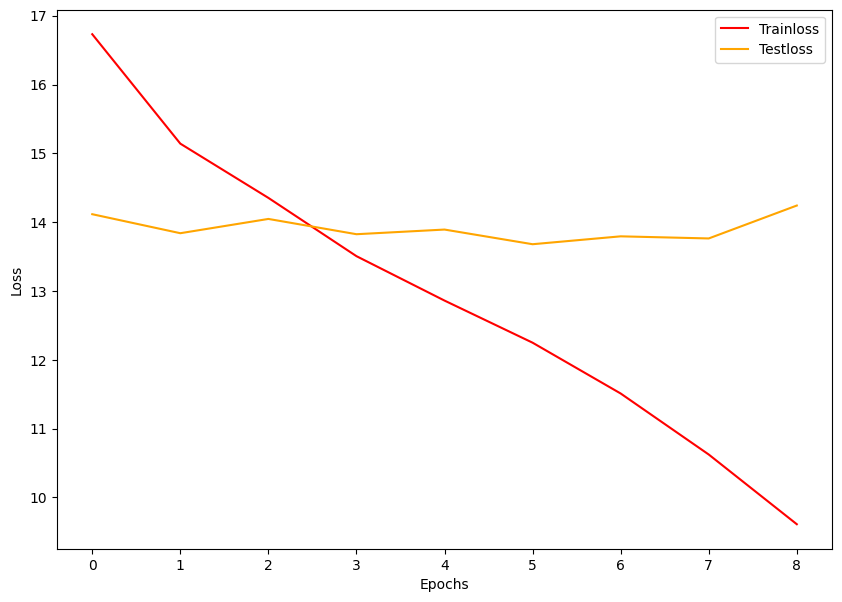

In [41]:
# 調低bs讓隨機性提升
# 調高tolerance及早觸發early stopping
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = CustomResNet().to(device,non_blocking=True)
net.load_state_dict(torch.load(r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights\CustomResNet_test0_retrain.pt"))

PATH = r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights"
modelname = "MyResNet_test2_retrain"

print(modelname)
torch.manual_seed(1412)
start = time() 
trainloss, testloss, trainacc, testacc = full_procedure(net,epochs=9, bs=128
                                             ,modelname=modelname
                                             ,PATH = PATH 
                                             ,lr=0.0001
                                             ,gamma=0
                                             ,tol = 10**(-4))
print(time()-start)
plotloss(trainloss,testloss)

初始準確率即低於第一次數據增強組合, 調整學習率之後仍呈落後趨勢, 接下來使用第一次數據增強組合改用Adam作為優化器來嘗試突破

--------------------------

### 使用第一次數據增強組合, 並改用Adam作為優化器

In [15]:
def full_procedure(net,epochs,bs,modelname, PATH, lr=0.001,betas=(0.9, 0.999),wd=0,patience=5,tol=10**(-5)):
    
    torch.cuda.manual_seed(1412)
    torch.cuda.manual_seed_all(1412)
    torch.manual_seed(1412)
    
    # 分割數據
    batchdata = DataLoader(train,batch_size=bs,shuffle=True
                       ,drop_last=False)
    testdata = DataLoader(test,batch_size=bs,shuffle=False
                      ,drop_last=False)
    
    # 損失函數，優化算法
    criterion = nn.CrossEntropyLoss(reduction="sum")  # 進行損失函數計算時，最後輸出結果的計算模式
    opt = optim.Adam(net.parameters(),lr=lr
                        ,betas=betas,weight_decay=wd)
    
    # 訓練與測試
    trainloss, testloss, trainacc, testacc = fit_test(net,batchdata,testdata,criterion,opt,epochs,patience,tol,modelname,PATH)
    
    return trainloss, testloss, trainacc, testacc

CustomResNet_test0_Adam
Epoch1:[8000/732570(1%)]
Epoch1:[16000/732570(2%)]
Epoch1:[24000/732570(3%)]
Epoch1:[32000/732570(4%)]
Epoch1:[40000/732570(5%)]
Epoch1:[48000/732570(7%)]
Epoch1:[56000/732570(8%)]
Epoch1:[64000/732570(9%)]
Epoch1:[72000/732570(10%)]
	 Train Loss:68.377821, Test Loss:29.361908, Train Acc:77.924%, Test Acc:91.330%
Epoch2:[81257/732570(11%)]
Epoch2:[89257/732570(12%)]
Epoch2:[97257/732570(13%)]
Epoch2:[105257/732570(14%)]
Epoch2:[113257/732570(15%)]
Epoch2:[121257/732570(17%)]
Epoch2:[129257/732570(18%)]
Epoch2:[137257/732570(19%)]
Epoch2:[145257/732570(20%)]
	 Train Loss:35.657357, Test Loss:24.087786, Train Acc:89.095%, Test Acc:93.085%
	 Weight Saved
Epoch3:[154514/732570(21%)]
Epoch3:[162514/732570(22%)]
Epoch3:[170514/732570(23%)]
Epoch3:[178514/732570(24%)]
Epoch3:[186514/732570(25%)]
Epoch3:[194514/732570(27%)]
Epoch3:[202514/732570(28%)]
Epoch3:[210514/732570(29%)]
Epoch3:[218514/732570(30%)]
	 Train Loss:30.485872, Test Loss:21.260240, Train Acc:90.784%, 

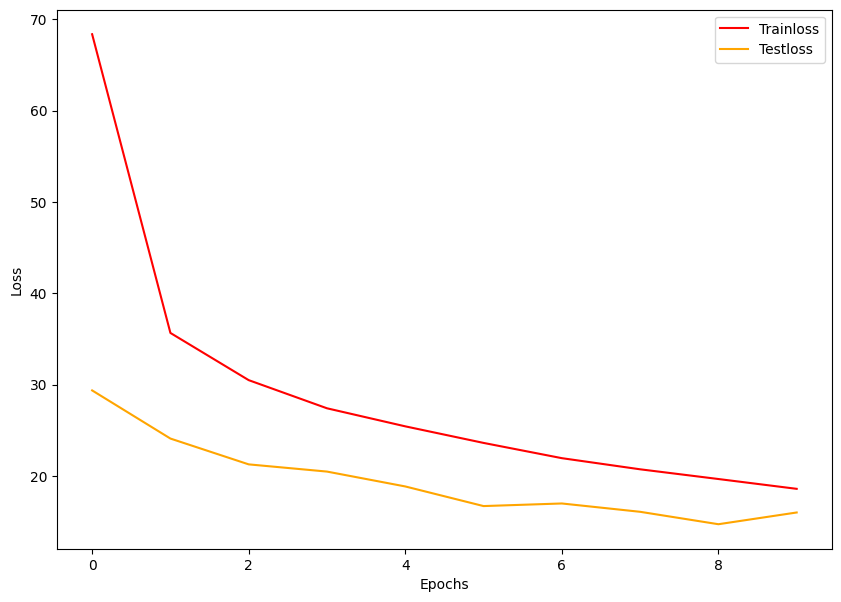

In [16]:
# 訓練10個epochs
PATH = r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights"
modelname = "CustomResNet_test0_Adam"

print(modelname)
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = CustomResNet().to(device,non_blocking=True)
start = time()
trainloss, testloss, trainacc, testacc = full_procedure(net,epochs=10, bs=64
                                          ,modelname=modelname
                                          ,PATH = PATH)
print(time()-start)
plotloss(trainloss,testloss)

CustomResNet_test1_Adam
Epoch1:[32000/1465140(2%)]
Epoch1:[64000/1465140(4%)]
	 Train Loss:15.442649, Test Loss:13.506829, Train Acc:95.599%, Test Acc:96.381%
Epoch2:[105257/1465140(7%)]
Epoch2:[137257/1465140(9%)]
	 Train Loss:13.817358, Test Loss:14.771971, Train Acc:96.039%, Test Acc:96.059%
	 NOTICE: Early stopping counter 1 of 5
Epoch3:[178514/1465140(12%)]
Epoch3:[210514/1465140(14%)]
	 Train Loss:12.785230, Test Loss:14.297643, Train Acc:96.279%, Test Acc:96.331%
	 NOTICE: Early stopping counter 2 of 5
Epoch4:[251771/1465140(17%)]
Epoch4:[283771/1465140(19%)]
	 Train Loss:11.857136, Test Loss:14.878539, Train Acc:96.559%, Test Acc:96.016%
	 NOTICE: Early stopping counter 3 of 5
Epoch5:[325028/1465140(22%)]
Epoch5:[357028/1465140(24%)]
	 Train Loss:10.860481, Test Loss:14.430338, Train Acc:96.793%, Test Acc:96.389%
	 Weight Saved
	 NOTICE: Early stopping counter 4 of 5
Epoch6:[398285/1465140(27%)]
Epoch6:[430285/1465140(29%)]
	 Train Loss:10.194891, Test Loss:15.407877, Train Acc

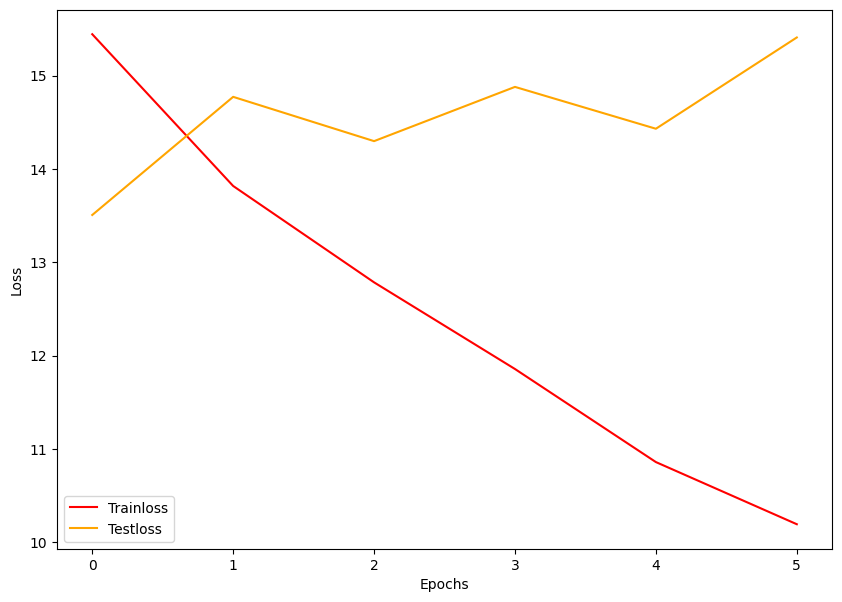

In [25]:
# Trainloss > Testloss, 模型表現欠擬合, 再進行更多訓練
# 加載之前保存的權重, 調低tolerance, 再訓練20個Epoch
# 調大bs, 看testloss表現會不會變平穩
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = CustomResNet().to(device,non_blocking=True)
net.load_state_dict(torch.load(r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights\CustomResNet_test0_Adam.pt"))

# 修改modelname，準備好保存結果
modelname = "CustomResNet_test1_Adam"

print(modelname)
torch.manual_seed(1412)
start = time() 
trainloss, testloss, trainacc, testacc = full_procedure(net,epochs=20, bs=256
                                             ,modelname=modelname
                                             ,PATH = PATH 
                                             ,tol = 10**(-10))
total_time = time()-start
print("{} minutes, {} seconds.".format(total_time//60, total_time%60))
plotloss(trainloss,testloss)

MyResNet_test2_Adam
Epoch1:[32000/1465140(2%)]
Epoch1:[64000/1465140(4%)]
	 Train Loss:13.645527, Test Loss:12.889313, Train Acc:96.145%, Test Acc:96.773%
Epoch2:[105257/1465140(7%)]
Epoch2:[137257/1465140(9%)]
	 Train Loss:12.112925, Test Loss:12.554672, Train Acc:96.594%, Test Acc:96.735%
Epoch3:[178514/1465140(12%)]
Epoch3:[210514/1465140(14%)]
	 Train Loss:11.285452, Test Loss:12.460933, Train Acc:96.824%, Test Acc:96.827%
	 Weight Saved
Epoch4:[251771/1465140(17%)]
Epoch4:[283771/1465140(19%)]
	 Train Loss:10.771806, Test Loss:12.412483, Train Acc:96.976%, Test Acc:96.858%
	 Weight Saved
Epoch5:[325028/1465140(22%)]
Epoch5:[357028/1465140(24%)]
	 Train Loss:10.094186, Test Loss:12.413532, Train Acc:97.290%, Test Acc:96.873%
	 Weight Saved
	 NOTICE: Early stopping counter 1 of 5
Epoch6:[398285/1465140(27%)]
Epoch6:[430285/1465140(29%)]
	 Train Loss:9.586361, Test Loss:12.612441, Train Acc:97.309%, Test Acc:96.839%
	 NOTICE: Early stopping counter 2 of 5
Epoch7:[471542/1465140(32%)]

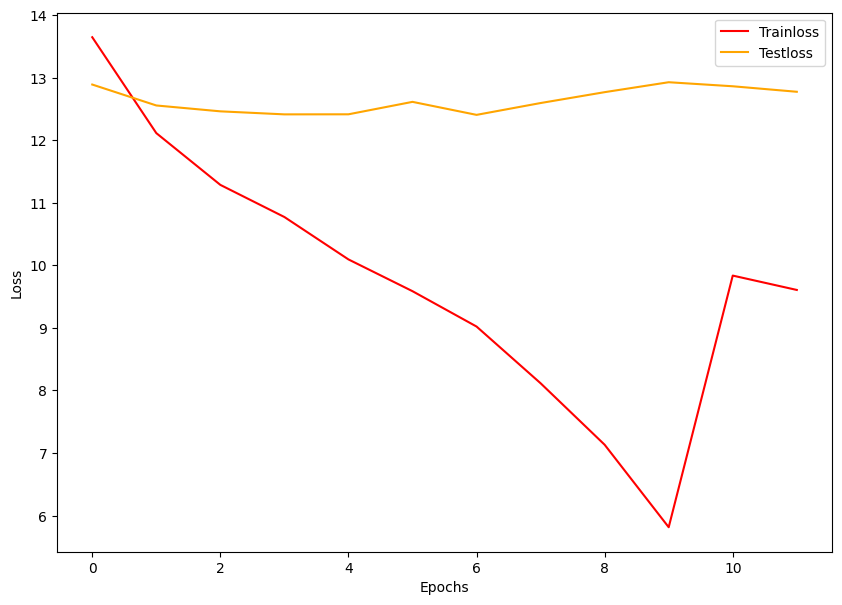

In [79]:
# trainloss有顯著下降並低於testloss, 多疊代幾輪有改善欠擬合
# testloss呈現不穩定且向上趨勢, 有輕微過擬合現象, 從訓練10個epoch的模型開始, 調低初始學習率做訓練
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = CustomResNet().to(device,non_blocking=True)
net.load_state_dict(torch.load(r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights\CustomResNet_test0_Adam.pt"))

PATH = r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights"
modelname = "MyResNet_test2_Adam"

print(modelname)
torch.manual_seed(1412)
start = time() 
trainloss, testloss, trainacc, testacc = full_procedure(net,epochs=20, bs=256
                                             ,modelname=modelname
                                             ,PATH = PATH 
                                             ,lr=0.0001
                                             ,tol = 10**(-10))

total_time = time()-start
print("{} minutes, {:.0f} seconds.".format(total_time//60, total_time%60))
plotloss(trainloss,testloss)

MyResNet_test2_Adam
Epoch1:[8000/1465140(1%)]
Epoch1:[16000/1465140(1%)]
Epoch1:[24000/1465140(2%)]
Epoch1:[32000/1465140(2%)]
Epoch1:[40000/1465140(3%)]
Epoch1:[48000/1465140(3%)]
Epoch1:[56000/1465140(4%)]
Epoch1:[64000/1465140(4%)]
Epoch1:[72000/1465140(5%)]
	 Train Loss:13.667425, Test Loss:12.808984, Train Acc:96.144%, Test Acc:96.731%
Epoch2:[81257/1465140(6%)]
Epoch2:[89257/1465140(6%)]
Epoch2:[97257/1465140(7%)]
Epoch2:[105257/1465140(7%)]
Epoch2:[113257/1465140(8%)]
Epoch2:[121257/1465140(8%)]
Epoch2:[129257/1465140(9%)]
Epoch2:[137257/1465140(9%)]
Epoch2:[145257/1465140(10%)]
	 Train Loss:12.112423, Test Loss:12.435895, Train Acc:96.563%, Test Acc:96.754%
	 Weight Saved
Epoch3:[154514/1465140(11%)]
Epoch3:[162514/1465140(11%)]
Epoch3:[170514/1465140(12%)]
Epoch3:[178514/1465140(12%)]
Epoch3:[186514/1465140(13%)]
Epoch3:[194514/1465140(13%)]
Epoch3:[202514/1465140(14%)]
Epoch3:[210514/1465140(14%)]
Epoch3:[218514/1465140(15%)]
	 Train Loss:11.170191, Test Loss:12.452658, Train

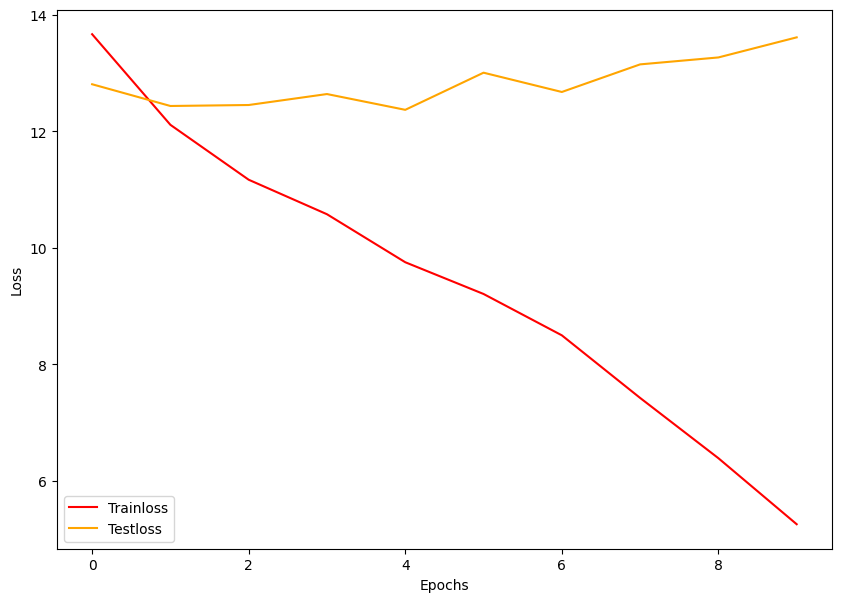

In [80]:
# 降低bs讓隨機性提升抵抗過擬合, 提高tol以便及早觸發提早停止
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = CustomResNet().to(device,non_blocking=True)
net.load_state_dict(torch.load(r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights\CustomResNet_test0_Adam.pt"))

PATH = r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights"
modelname = "MyResNet_test2_Adam"

print(modelname)
torch.manual_seed(1412)
start = time() 
trainloss, testloss, trainacc, testacc = full_procedure(net,epochs=20, bs=64
                                             ,modelname=modelname
                                             ,PATH = PATH 
                                             ,lr=0.0001
                                             ,tol = 10**(-5))

total_time = time()-start
print("{} minutes, {:.0f} seconds.".format(total_time//60, total_time%60))
plotloss(trainloss,testloss)

MyResNet_test2_Adam
Epoch1:[8000/1465140(1%)]
Epoch1:[16000/1465140(1%)]
Epoch1:[24000/1465140(2%)]
Epoch1:[32000/1465140(2%)]
Epoch1:[40000/1465140(3%)]
Epoch1:[48000/1465140(3%)]
Epoch1:[56000/1465140(4%)]
Epoch1:[64000/1465140(4%)]
Epoch1:[72000/1465140(5%)]
	 Train Loss:14.489709, Test Loss:12.492994, Train Acc:95.893%, Test Acc:96.666%
Epoch2:[81257/1465140(6%)]
Epoch2:[89257/1465140(6%)]
Epoch2:[97257/1465140(7%)]
Epoch2:[105257/1465140(7%)]
Epoch2:[113257/1465140(8%)]
Epoch2:[121257/1465140(8%)]
Epoch2:[129257/1465140(9%)]
Epoch2:[137257/1465140(9%)]
Epoch2:[145257/1465140(10%)]
	 Train Loss:12.886674, Test Loss:12.525454, Train Acc:96.376%, Test Acc:96.735%
	 Weight Saved
	 NOTICE: Early stopping counter 1 of 5
Epoch3:[154514/1465140(11%)]
Epoch3:[162514/1465140(11%)]
Epoch3:[170514/1465140(12%)]
Epoch3:[178514/1465140(12%)]
Epoch3:[186514/1465140(13%)]
Epoch3:[194514/1465140(13%)]
Epoch3:[202514/1465140(14%)]
Epoch3:[210514/1465140(14%)]
Epoch3:[218514/1465140(15%)]
	 Train Lo

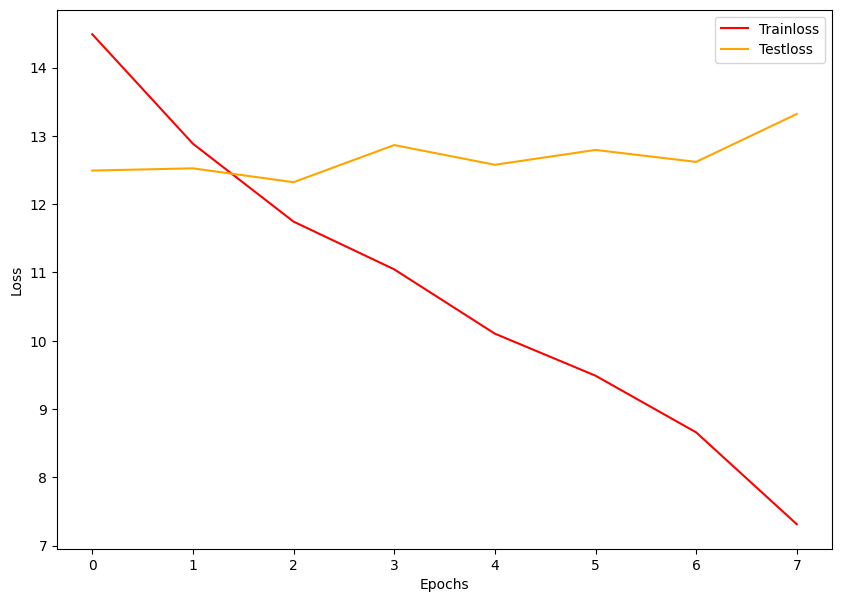

In [26]:
# 增加wd, 提高tol以便及早觸發提早停止
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = CustomResNet().to(device,non_blocking=True)
net.load_state_dict(torch.load(r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights\CustomResNet_test0_Adam.pt"))

PATH = r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights"
modelname = "MyResNet_test2_Adam"

print(modelname)
torch.manual_seed(1412)
start = time() 
trainloss, testloss, trainacc, testacc = full_procedure(net,epochs=20, bs=64
                                             ,modelname=modelname
                                             ,PATH = PATH 
                                             ,lr=0.0001
                                             ,wd=0.0001
                                             ,tol = 10**(-4))

total_time = time()-start
print("{} minutes, {:.0f} seconds.".format(total_time//60, total_time%60))
plotloss(trainloss,testloss)

MyResNet_test2_Adam
Epoch1:[32000/659313(5%)]
Epoch1:[64000/659313(10%)]
	 Train Loss:14.419919, Test Loss:12.741633, Train Acc:95.924%, Test Acc:96.723%
Epoch2:[105257/659313(16%)]
Epoch2:[137257/659313(21%)]
	 Train Loss:12.913799, Test Loss:12.527617, Train Acc:96.403%, Test Acc:96.796%
	 Weight Saved
Epoch3:[178514/659313(27%)]
Epoch3:[210514/659313(32%)]
	 Train Loss:12.036138, Test Loss:12.413120, Train Acc:96.540%, Test Acc:96.827%
	 Weight Saved
Epoch4:[251771/659313(38%)]
Epoch4:[283771/659313(43%)]
	 Train Loss:11.216654, Test Loss:12.425193, Train Acc:96.847%, Test Acc:96.819%
	 NOTICE: Early stopping counter 1 of 5
Epoch5:[325028/659313(49%)]
Epoch5:[357028/659313(54%)]
	 Train Loss:10.570576, Test Loss:12.444129, Train Acc:97.071%, Test Acc:96.862%
	 Weight Saved
	 NOTICE: Early stopping counter 2 of 5
Epoch6:[398285/659313(60%)]
Epoch6:[430285/659313(65%)]
	 Train Loss:10.005377, Test Loss:12.418167, Train Acc:97.251%, Test Acc:96.812%
	 NOTICE: Early stopping counter 3 o

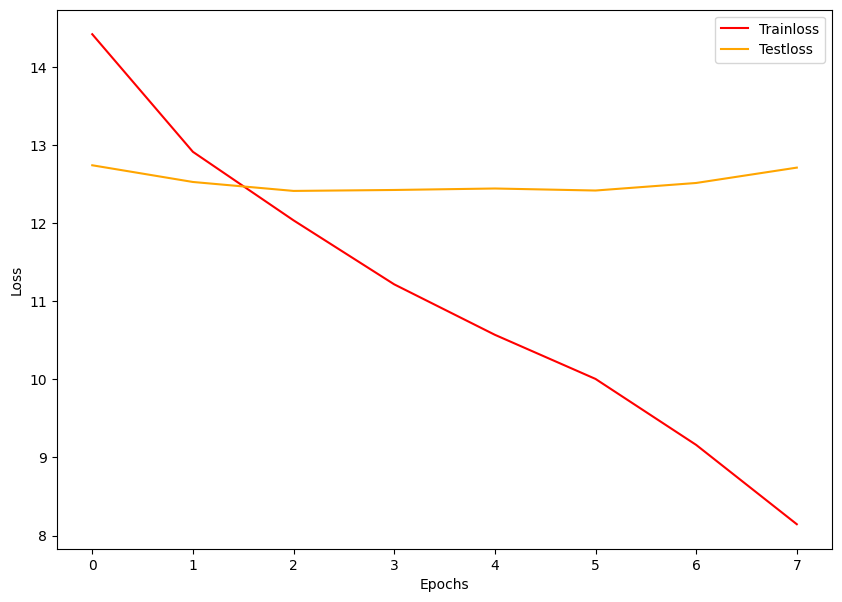

In [17]:
# 調整bs回到256, 不加入wd, 基於第一次訓練的基礎再訓練9個Epochs就停止
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = CustomResNet().to(device,non_blocking=True)
net.load_state_dict(torch.load(r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights\CustomResNet_test0_Adam.pt"))

PATH = r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights"
modelname = "MyResNet_test2_Adam"

print(modelname)
torch.manual_seed(1412)
start = time() 
trainloss, testloss, trainacc, testacc = full_procedure(net,epochs=9, bs=256
                                             ,modelname=modelname
                                             ,PATH = PATH 
                                             ,lr=0.0001
                                             ,tol = 10**(-10))

total_time = time()-start
print("{} minutes, {:.0f} seconds.".format(total_time//60, total_time%60))
plotloss(trainloss,testloss)

MyResNet_test2_Adam
Epoch1:[8000/659313(1%)]
Epoch1:[16000/659313(2%)]
Epoch1:[24000/659313(4%)]
Epoch1:[32000/659313(5%)]
Epoch1:[40000/659313(6%)]
Epoch1:[48000/659313(7%)]
Epoch1:[56000/659313(8%)]
Epoch1:[64000/659313(10%)]
Epoch1:[72000/659313(11%)]
	 Train Loss:14.480452, Test Loss:12.636874, Train Acc:95.887%, Test Acc:96.758%
Epoch2:[81257/659313(12%)]
Epoch2:[89257/659313(14%)]
Epoch2:[97257/659313(15%)]
Epoch2:[105257/659313(16%)]
Epoch2:[113257/659313(17%)]
Epoch2:[121257/659313(18%)]
Epoch2:[129257/659313(20%)]
Epoch2:[137257/659313(21%)]
Epoch2:[145257/659313(22%)]
	 Train Loss:12.859780, Test Loss:12.599609, Train Acc:96.389%, Test Acc:96.739%
Epoch3:[154514/659313(23%)]
Epoch3:[162514/659313(25%)]
Epoch3:[170514/659313(26%)]
Epoch3:[178514/659313(27%)]
Epoch3:[186514/659313(28%)]
Epoch3:[194514/659313(30%)]
Epoch3:[202514/659313(31%)]
Epoch3:[210514/659313(32%)]
Epoch3:[218514/659313(33%)]
	 Train Loss:11.888378, Test Loss:12.432468, Train Acc:96.602%, Test Acc:96.827%
	

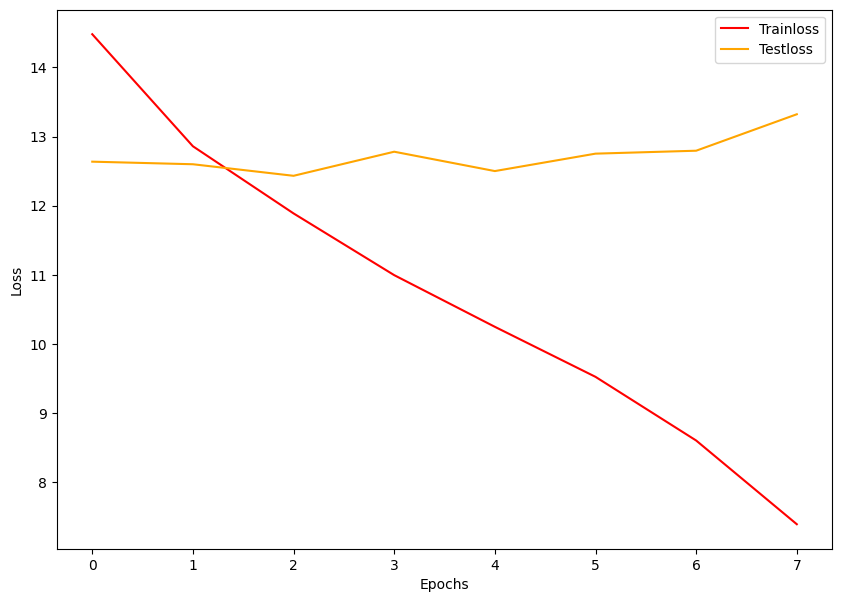

In [21]:
# 降低bs讓隨機性提升抵抗過擬合, 再訓練9個Epochs
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = CustomResNet().to(device,non_blocking=True)
net.load_state_dict(torch.load(r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights\CustomResNet_test0_Adam.pt"))

PATH = r"D:\TGI102_AI_BootCamp\Pytorch\SVHN_Weights"
modelname = "MyResNet_test2_Adam"

print(modelname)
torch.manual_seed(1412)
start = time() 
trainloss, testloss, trainacc, testacc = full_procedure(net,epochs=9, bs=64
                                             ,modelname=modelname
                                             ,PATH = PATH 
                                             ,lr=0.0001
                                             ,tol = 10**(-5))

total_time = time()-start
print("{} minutes, {:.0f} seconds.".format(total_time//60, total_time%60))
plotloss(trainloss,testloss)

經過測試, 在數據預處理中使用銳化的準確率最佳; 在優化器的選擇部分, RMSprop或Adam的表現差異不大, 但經過調整, Adam優化器的準確率可以較為穩定地落在96.8XX%; Adam優化器搭配學習率, Batch_size的調整及Early Stop, 測試集最高準確率可達到96.911%